# 타이타닉 모델 비교 (전처리 2종 × 모델 2종)
- 전처리: 기존 vs 업그레이드
- 모델: scikit-learn(RandomForest) vs PyTorch(로지스틱 회귀)
- 총 4가지 조합의 검증 정확도 비교


In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler

import torch
import torch.nn as nn
import torch.optim as optim


## 데이터 로딩
- 같은 폴더에 train.csv, test.csv가 있다고 가정
- Colab이면 파일 업로드 후 경로를 맞춰주세요


In [24]:
from google.colab import drive
import os
os.path.exists('/content/drive/MyDrive')
drive.mount('/content/drive')

train = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/ML_titanic/train.csv')
test = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/ML_titanic/test.csv')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## 전처리 함수 (기존 vs 업그레이드)
- 기존: Embarked 결측 제거, Age/Fare 평균 대체, Sex/Embarked 숫자 인코딩
- 업그레이드: 결측 여부 플래그 + FamilySize + Name_has_title 추가


In [25]:
def baseline_preprocess(df, mode='train', stats=None):
    df = df.copy()
    if mode == 'train':
        df = df.dropna(subset=['Embarked']).copy()
        embarked_mode = df['Embarked'].value_counts(dropna=True).idxmax()
        age_mean = df['Age'].mean()
        fare_mean = df['Fare'].mean()
        stats = {'embarked_mode': embarked_mode, 'age_mean': age_mean, 'fare_mean': fare_mean}

    # 결측치 채우기
    df['Age'] = df['Age'].fillna(stats['age_mean'])
    df['Fare'] = df['Fare'].fillna(stats['fare_mean'])
    df['Embarked'] = df['Embarked'].fillna(stats['embarked_mode'])

    # 문자열 -> 숫자
    df['Sex'] = df['Sex'].map({'male': 0, 'female': 1})
    embarked_map = {'C': 0, 'Q': 1, 'S': 2}
    df['Embarked'] = df['Embarked'].map(embarked_map)

    feature_cols = ['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked']
    return df, stats, feature_cols

def upgraded_preprocess(df, mode='train', stats=None):
    df = df.copy()
    if mode == 'train':
        embarked_mode = df['Embarked'].value_counts(dropna=True).idxmax()
        age_mean = df['Age'].mean().round(2)
        fare_mean = df['Fare'].mean().round(2)
        stats = {'embarked_mode': embarked_mode, 'age_mean': age_mean, 'fare_mean': fare_mean}

    # 결측 여부 플래그
    df['Embarked_isna'] = df['Embarked'].isna().astype(int)
    df['Age_isna'] = df['Age'].isna().astype(int)
    df['Cabin_isna'] = df['Cabin'].isna().astype(int)

    # 결측치 채우기
    df['Embarked'] = df['Embarked'].fillna(stats['embarked_mode'])
    df['Age'] = df['Age'].fillna(stats['age_mean'])
    df['Fare'] = df['Fare'].fillna(stats['fare_mean'])

    # 문자열 -> 숫자
    df['Sex'] = df['Sex'].map({'male': 0, 'female': 1})
    embarked_map = {'C': 0, 'Q': 1, 'S': 2}
    df['Embarked'] = df['Embarked'].map(embarked_map)

    # 파생 변수
    df['FamilySize'] = df['SibSp'] + df['Parch'] + 1
    df['Name_has_title'] = df['Name'].str.contains(
        'Master|Dr|Rev|Major|Col|Capt|Jonkheer|Don|Countess|Sir', regex=True
    ).astype(int)

    # 필요 없는 컬럼 제거
    df = df.drop(columns=['Name', 'Ticket', 'Cabin'])

    feature_cols = [
        'Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked',
        'Embarked_isna', 'Age_isna', 'Cabin_isna', 'FamilySize', 'Name_has_title'
    ]
    return df, stats, feature_cols


## 데이터 분리 (전처리별로 8:2 분리)


In [26]:
# 기존 전처리
baseline_train, baseline_stats, baseline_features = baseline_preprocess(train, 'train')
Xb = baseline_train[baseline_features]
yb = baseline_train['Survived']
Xb_train, Xb_val, yb_train, yb_val = train_test_split(
    Xb, yb, test_size=0.2, random_state=42, stratify=yb
)

# 업그레이드 전처리
up_train, up_stats, up_features = upgraded_preprocess(train, 'train')
Xu = up_train[up_features]
yu = up_train['Survived']
Xu_train, Xu_val, yu_train, yu_val = train_test_split(
    Xu, yu, test_size=0.2, random_state=42, stratify=yu
)


## 모델 평가 (4가지 조합)
- Baseline + RandomForest
- Baseline + PyTorch 로지스틱
- Upgraded + RandomForest
- Upgraded + PyTorch 로지스틱


In [27]:
def torch_logistic_acc(X_train_df, y_train_s, X_val_df, y_val_s, epochs=200, lr=0.01):
    # 표준화 (PyTorch 안정화)
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train_df)
    X_val = scaler.transform(X_val_df)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    X_train_t = torch.tensor(X_train, dtype=torch.float32).to(device)
    y_train_t = torch.tensor(y_train_s.values, dtype=torch.float32).view(-1, 1).to(device)
    X_val_t = torch.tensor(X_val, dtype=torch.float32).to(device)
    y_val_t = torch.tensor(y_val_s.values, dtype=torch.float32).view(-1, 1).to(device)
    model = nn.Linear(X_train_t.shape[1], 1).to(device)
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.SGD(model.parameters(), lr=lr)
    for _ in range(epochs):
        model.train()
        optimizer.zero_grad()
        logits = model(X_train_t)
        loss = criterion(logits, y_train_t)
        loss.backward()
        optimizer.step()
    model.eval()
    with torch.no_grad():
        probs = torch.sigmoid(model(X_val_t))
        pred = (probs >= 0.5).float()
        acc = (pred.eq(y_val_t)).float().mean().item()
        y_true = y_val_s.values
        y_pred = pred.cpu().numpy().astype(int).ravel()
        f1 = f1_score(y_true, y_pred)
    return acc, f1

results = {}
f1_results = {}

# Baseline + RandomForest
sk_base = RandomForestClassifier(n_estimators=200, random_state=42)
sk_base.fit(Xb_train, yb_train)
pred = sk_base.predict(Xb_val)
results['Baseline + RandomForest'] = accuracy_score(yb_val, pred)
f1_results['Baseline + RandomForest'] = f1_score(yb_val, pred)

# Baseline + PyTorch
acc, f1 = torch_logistic_acc(Xb_train, yb_train, Xb_val, yb_val, epochs=200, lr=0.01)
results['Baseline + PyTorch'] = acc
f1_results['Baseline + PyTorch'] = f1

# Upgraded + RandomForest
sk_up = RandomForestClassifier(n_estimators=200, random_state=42)
sk_up.fit(Xu_train, yu_train)
pred = sk_up.predict(Xu_val)
results['Upgraded + RandomForest'] = accuracy_score(yu_val, pred)
f1_results['Upgraded + RandomForest'] = f1_score(yu_val, pred)

# Upgraded + PyTorch
acc, f1 = torch_logistic_acc(Xu_train, yu_train, Xu_val, yu_val, epochs=200, lr=0.01)
results['Upgraded + PyTorch'] = acc
f1_results['Upgraded + PyTorch'] = f1

print('Accuracy:')
for k, v in results.items():
    print(f'{k}: {v:.4f}')

print('F1-score:')
for k, v in f1_results.items():
    print(f'{k}: {v:.4f}')


Baseline + RandomForest: 0.7978
Baseline + PyTorch: 0.7528
Upgraded + RandomForest: 0.8045
Upgraded + PyTorch: 0.7933


## 성능 비교 시각화 (4가지 조합)


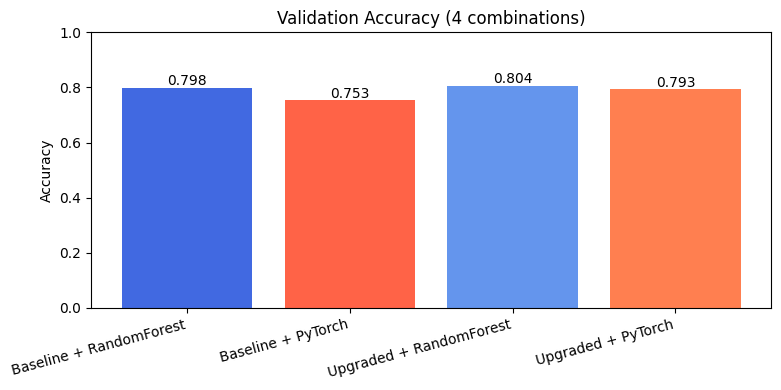

In [28]:
labels = list(results.keys())
scores = [results[k] for k in labels]

plt.figure(figsize=(8,4))
bars = plt.bar(labels, scores, color=['royalblue','tomato','cornflowerblue','coral'])
plt.ylim(0, 1)
plt.title('Validation Accuracy (4 combinations)')
plt.ylabel('Accuracy')
plt.xticks(rotation=15, ha='right')

for b, s in zip(bars, scores):
    plt.text(b.get_x() + b.get_width()/2, s + 0.01, f'{s:.3f}', ha='center')

plt.tight_layout()
plt.show()


## PyTorch 학습 곡선 (Train / Val Loss)
- Early Stopping으로 멈춘 지점까지 기록


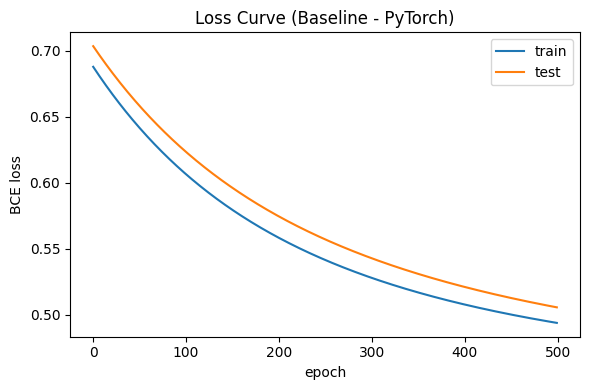

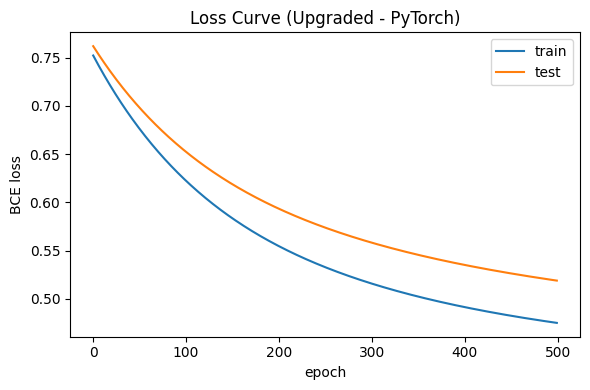

In [29]:
for name, hist in histories.items():
    plt.figure(figsize=(6,4))
    plt.plot(hist['train_loss'], label='train')
    plt.plot(hist['val_loss'], label='test')
    plt.title(f'Loss Curve ({name} - PyTorch)')
    plt.xlabel('epoch')
    plt.ylabel('BCE loss')
    plt.legend()
    plt.tight_layout()
    plt.show()


## K-Fold 검증
- StratifiedKFold로 클래스 비율 유지
- 전처리 2종 × 모델 2종의 평균 정확도 비교


K-Fold Results (mean ± std)
Baseline + RandomForest: 0.8167 ± 0.0220
Baseline + PyTorch:      0.7739 ± 0.0165
Upgraded + RandomForest: 0.8137 ± 0.0239
Upgraded + PyTorch:      0.7666 ± 0.0307


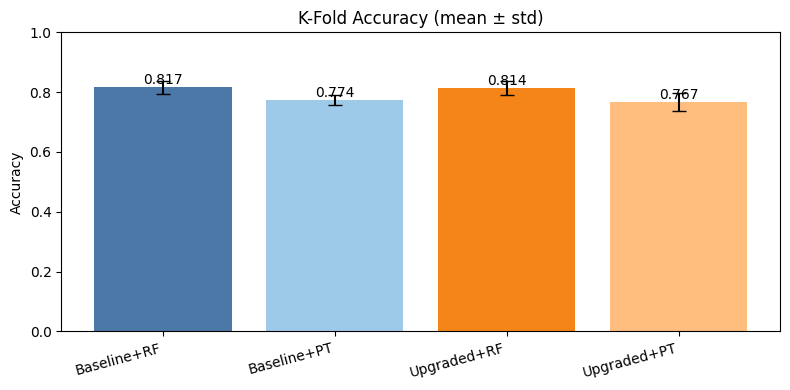

In [33]:
from sklearn.model_selection import StratifiedKFold

def rf_kfold_acc(X, y, n_splits=5, random_state=42):
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)
    scores = []
    f1_scores = []
    for train_idx, val_idx in skf.split(X, y):
        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
        model = RandomForestClassifier(n_estimators=200, random_state=42)
        model.fit(X_train, y_train)
        pred = model.predict(X_val)
        scores.append(accuracy_score(y_val, pred))
        f1_scores.append(f1_score(y_val, pred))
    return np.mean(scores), np.std(scores), np.mean(f1_scores), np.std(f1_scores)

def torch_kfold_acc(X, y, n_splits=5, random_state=42, epochs=200, lr=0.01):
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)
    scores = []
    f1_scores = []
    for train_idx, val_idx in skf.split(X, y):
        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
        acc, f1 = torch_logistic_acc(X_train, y_train, X_val, y_val, epochs=epochs, lr=lr)
        scores.append(acc)
        f1_scores.append(f1)
    return np.mean(scores), np.std(scores), np.mean(f1_scores), np.std(f1_scores)

# Baseline
rf_base_mean, rf_base_std, rf_base_f1_mean, rf_base_f1_std = rf_kfold_acc(Xb, yb)
pt_base_mean, pt_base_std, pt_base_f1_mean, pt_base_f1_std = torch_kfold_acc(Xb, yb)

# Upgraded
rf_up_mean, rf_up_std, rf_up_f1_mean, rf_up_f1_std = rf_kfold_acc(Xu, yu)
pt_up_mean, pt_up_std, pt_up_f1_mean, pt_up_f1_std = torch_kfold_acc(Xu, yu)

print('K-Fold Accuracy (mean +/- std)')
print(f'Baseline + RandomForest: {rf_base_mean:.4f} +/- {rf_base_std:.4f}')
print(f'Baseline + PyTorch:      {pt_base_mean:.4f} +/- {pt_base_std:.4f}')
print(f'Upgraded + RandomForest: {rf_up_mean:.4f} +/- {rf_up_std:.4f}')
print(f'Upgraded + PyTorch:      {pt_up_mean:.4f} +/- {pt_up_std:.4f}')

print('K-Fold F1-score (mean +/- std)')
print(f'Baseline + RandomForest: {rf_base_f1_mean:.4f} +/- {rf_base_f1_std:.4f}')
print(f'Baseline + PyTorch:      {pt_base_f1_mean:.4f} +/- {pt_base_f1_std:.4f}')
print(f'Upgraded + RandomForest: {rf_up_f1_mean:.4f} +/- {rf_up_f1_std:.4f}')
print(f'Upgraded + PyTorch:      {pt_up_f1_mean:.4f} +/- {pt_up_f1_std:.4f}')
